# Barrier Options:

Barrier options are characterized by a payoff that only occurs based on whether the asset price has reached a certain a barrier point during its lifetime. There are four types of barrier options:
1. Up and Out Option
2. Up and In Option
3. Down and Out Option
4. Down and In Option


The objective is to price to the barrier options using the following methods:
1. Montecarlo simulation
2. Finite Difference Methods

Also Compare with the closed form solution if available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
import warnings
warnings.filterwarnings('ignore')

The following parameters are same for all the options:

In [3]:
s0 = 500
K=600
r=0.05
T=0.75
vol=0.3

### 1. Up and Out Option

In the case of up and out option, the payoff does not occur if the option crosses a barrier during its lifetime. The option is said to be knocked out if it reaches the barrier. The option value must satisfy the black-scholes pde in the asset values below the barrier.

In [4]:
B_up_out = 900 #Barrier for the up and out option

**a) Montecarlo simulation:**

In [26]:
class Up_and_Out_Montecarlo():
    def __init__(self,s0,K,B,r,T,vol,n,paths,c=1):
        self.s0 = s0
        self.K =K
        self.r =r
        self.T=T
        self.vol =vol
        self.n =n
        self.paths =paths
        self.c =c
        self.B=B
        
    def generate_normal_random_variable(self):
        return np.random.randn(self.paths)
    
    def stock_matrix(self):
        
        dt = self.T/self.n
        stock_mat1 = np.empty(shape =(self.paths,self.n+1))
        stock_mat1[:,0] = self.s0
        
        stock_mat2 = np.empty(shape =(self.paths,self.n+1))
        stock_mat2[:,0] = self.s0
        
        for i in range(1,self.n+1):
            z1 = self.generate_normal_random_variable()
            z2=-z1
            stock_mat1[:,i] = stock_mat1[:,i-1]*np.exp((r-0.5*vol**2)*(dt)+vol*z1*dt**0.5)
            stock_mat2[:,i] = stock_mat2[:,i-1]*np.exp((r-0.5*vol**2)*(dt)+vol*z2*dt**0.5)
        return stock_mat1,stock_mat2
        
    def option_matrix(self,stock_mat):
        s = stock_mat
        payoff = np.maximum(0,np.where(self.c==1,1,-1)*(s[:,-1]-self.K))
        v = np.where(np.max(s,axis=1)>=self.B,0,payoff)*np.exp(-self.r*self.T)
        return v
    
    def get_option_price(self,stats =True):
        
        stock_mat1 = self.stock_matrix()[0]
        v1 = self.option_matrix(stock_mat1)
        
        stock_mat2 = self.stock_matrix()[1]
        v2 = self.option_matrix(stock_mat2)
        
        v=(v1+v2)/2
            
        price = sum(v)/self.paths
        SE = (np.var(v)/self.paths)**0.5
        CI = st.norm.interval(0.95,loc =price,scale = SE)
        #cat = np.where(self.c==1,'call','put')
        
        if stats==True:
            return price,SE,CI
        else:
            return price

In [27]:
up_out_MC_call = Up_and_Out_Montecarlo(s0,K,B_up_out,r,T,vol,100,10000,c=1)
val = up_out_MC_call.get_option_price(stats=True)
print(f'The price of the call option using monte carlo is {np.round(val[0],2)}')
print(f'The SE of the price of the call option is {np.round(val[1],2)}')
print(f'The 95% confidence interval of the price of the call option is {np.round(val[2],2)}')

print('------------------------------------------------------------------------------------')

up_out_MC_put = Up_and_Out_Montecarlo(s0,K,B_up_out,r,T,vol,100,10000,c=-1)
val = up_out_MC_put.get_option_price(stats=True)
print(f'The price of the put option using montecarlo is {np.round(val[0],2)}')
print(f'The SE of the price of the put option is {np.round(val[1],2)}')
print(f'The 95% confidence interval of the price of the put option is {np.round(val[2],2)}')


The price of the call option using monte carlo is 18.97
The SE of the price of the call option is 0.33
The 95% confidence interval of the price of the call option is [18.32 19.62]
------------------------------------------------------------------------------------
The price of the put option using montecarlo is 103.75
The SE of the price of the put option is 0.65
The 95% confidence interval of the price of the put option is [102.48 105.01]


**b) Finite Difference Methods:**

Here we use the crank nicholson method to solve the black scholes pde since it is the most accurate.

In [7]:
class Up_and_Out_FDM():
    def __init__(self):
        pass
    
    def grid(self,NTS,T,Smax,NAS):
        s_values = [j*Smax/NAS for j in range(0,NAS+1)]
        t_values = [i*T/NTS for i in range(0,NTS+1)]
        grid = [np.zeros(NAS+1) for i in range(NTS+1)]
        return {'Time':t_values,'Stock':s_values,'Grid':grid}
    
    def CN_pms(self,s,ds,dt,r,vol):
        A = -r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        B = -1/dt-vol**2*s**2/(2*ds**2)-r/2
        C = r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        D = 1/dt-vol**2*s**2/(2*ds**2)-r/2
        return A,B,C,D
    
    def CN_matrix(self,s_values,ds,dt,r,vol):
        M=len(s_values)
        matrix_1 = np.zeros(shape=(M-2,M))
        matrix_2 = np.zeros(shape=(M-2,M))
        for j in range(1,M-1):
            A,B,C,D = self.CN_pms(s_values[j],ds,dt,r,vol)
            matrix_1[j-1,j-1] = A
            matrix_1[j-1,j] = B
            matrix_1[j-1,j+1] = C

            matrix_2[j-1,j-1] = A
            matrix_2[j-1,j] = D
            matrix_2[j-1,j+1] = C
        return matrix_1,matrix_2
    
    def CN_method(self,grid_dict,K,B,r,vol,call=1):
        v = grid_dict['Grid']
        s = np.array(grid_dict['Stock'])
        t = grid_dict['Time']
        dt = t[1]-t[0]
        ds = s[1]-s[0]
        if call ==1:
            c =1
        else:
            c=-1
        payoff  = np.where(s>=B,0,np.maximum(c*(s-K),0))
        v[-1] =payoff
        matrices =self.CN_matrix(s,ds,dt,r,vol)

        matrix_1 = matrices[0]
        matrix_2 = matrices[1]

        for i in range(len(t)-2,-1,-1):
            v[i][0] = np.maximum(c*(s[0]-K*np.exp(-r*(t[-1]-t[i]))),0)
            v[i][-1] = 0
            v2 = v[i+1]
            M_2 = np.matmul(matrix_2,v2)
            r_1 = matrix_1[:,0]*v[i][0]+matrix_1[:,-1]*v[i][-1]
            M_1 = matrix_1[:,1:len(s)-1]
            v[i][1:len(s)-1] = np.matmul(np.linalg.inv(M_1),-M_2-r_1)
            

        grid_dict['Grid'] = v

        g = pd.DataFrame(data = grid_dict['Grid'],index=grid_dict['Time'],columns=grid_dict['Stock'])
        g.index.name = 'Time'
        g.columns.name ='Stock Price'    

        return g

In [8]:
up_out_FDM = Up_and_Out_FDM()
g = up_out_FDM.grid(100,T,B_up_out,100)

call_val = up_out_FDM.CN_method(g,K,B_up_out,r,vol,call=1).iloc[0,:]
print(f'The price of the call option using FDM is {np.round(np.interp(s0,call_val.index,call_val.values),2)}')

put_val = up_out_FDM.CN_method(g,K,B_up_out,r,vol,call=-1).iloc[0,:]
print(f'The price of the put option using FDM is {np.round(np.interp(s0,put_val.index,put_val.values),2)}')

The price of the call option using FDM is 17.87
The price of the put option using FDM is 103.06


**c) Closed Form Solution:**

In [9]:
def black_scholes(S0,K,r,T,vol,call=1):
    d1 = (np.log(S0/K)+(r+0.5*vol**2)*(T))/(vol*(T**0.5))
    d2 = d1-(vol*(T**0.5))
    if call == 1:
        price = S0*st.norm.cdf(d1)-K*np.exp(-r*T)*st.norm.cdf(d2)
    else:
        price =-S0*st.norm.cdf(-d1)+K*np.exp(-r*T)*st.norm.cdf(-d2)
    return price

In [10]:
def up_and_out_CF(S0,K,B,r,T,vol,call=1):
    l = (r+0.5*vol**2)/vol**2
    y = np.log(B**2/(S0*K))/(vol*(T**0.5))+l*(vol*(T**0.5))
    x1 = np.log(S0/B)/(vol*(T**0.5))+l*(vol*(T**0.5))
    y1 = np.log(B/S0)/(vol*(T**0.5))+l*(vol*(T**0.5))
    
    N = st.norm.cdf
    if S0<B:
        if call==1:
            if B>K:
                v = black_scholes(S0,K,r,T,vol,call=1)- \
                    (S0*N(x1)-K*np.exp(-r*T)*N(x1-vol*T**0.5)- \
                    (S0*(B/S0)**(2*l))*(N(-y)-N(-y1))+ \
                    K*np.exp(-r*T)*(B/S0)**(2*l-2)*(N(-y+vol*T**0.5)-N(-y1+vol*T**0.5)))
            else:
                v=0
        else:
            if B>K:
                v = black_scholes(S0,K,r,T,vol,call=-1)- \
                    (-S0*(B/S0)**(2*l)*N(-y)+K*np.exp(-r*T)*(B/S0)**(2*l-2)*N(-y+vol*T**0.5))
            else:
                v = -S0*N(-x1)+K*np.exp(-r*T)*N(-x1+vol*T**0.5)+ \
                    S0*(B/S0)**(2*l)*N(-y1)-K*np.exp(-r*T)*(B/S0)**(2*l-2)*N(-y1+vol*T**0.5)
    else:
        v=0
    return v

In [11]:
print(f'The price of the up and out call using Closed form Solution is {round(up_and_out_CF(s0,K,B_up_out,r,T,vol,call=1),2)}')
print(f'The price of the up and out put using Closed form Solution is {round(up_and_out_CF(s0,K,B_up_out,r,T,vol,call=-1),2)}')

The price of the up and out call using Closed form Solution is 17.87
The price of the up and out put using Closed form Solution is 103.03


**Comparison of Montecarlo and Finite Difference Methods for Up and Out Barrier Options**

In [12]:
s1 = np.linspace(500,1000,21)

In [29]:
call_MC = [Up_and_Out_Montecarlo(x,K,B_up_out,r,T,vol,100,10000,c=1).get_option_price(stats=False) 
           for x in s1]
put_MC = [Up_and_Out_Montecarlo(x,K,B_up_out,r,T,vol,100,10000,c=-1).get_option_price(stats=False) 
           for x in s1]

call_FDM = np.interp(s1,call_val.index,call_val.values)
put_FDM = np.interp(s1,call_val.index,put_val.values)

call_CF = [up_and_out_CF(x,K,B_up_out,r,T,vol,call=1) for x in s1]
put_CF = [up_and_out_CF(x,K,B_up_out,r,T,vol,call=-1) for x in s1]

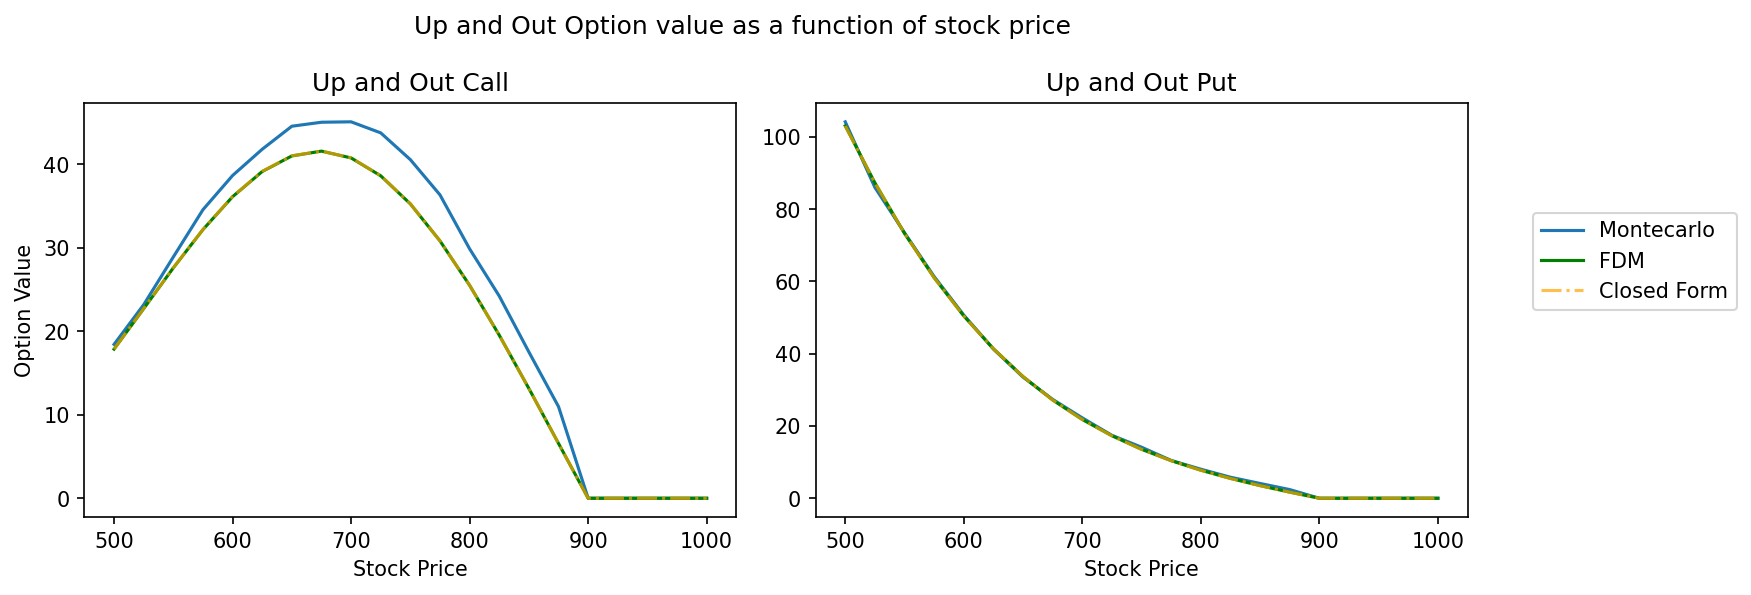

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=150)

ax[0].plot(s1,call_MC,label='Montecarlo')
ax[0].plot(s1,call_FDM,label='FDM',color='green')
ax[0].plot(s1,call_CF,label='Closed Form',color='orange',alpha=0.7,ls='-.')
ax[0].set_xlabel('Stock Price')
ax[0].set_ylabel('Option Value')
ax[0].set_title('Up and Out Call')

ax[1].plot(s1,put_MC,label='Montecarlo')
ax[1].plot(s1,put_FDM,label='FDM',color='green')
ax[1].plot(s1,put_CF,label='Closed Form',color='orange',alpha=0.7,ls='-.')
ax[1].set_xlabel('Stock Price')
ax[1].set_title('Up and Out Put')

plt.suptitle("Up and Out Option value as a function of stock price")
plt.tight_layout()
plt.legend(loc=(1.1,0.5))

We could see that Finite Difference eactly replicates the closed form solution in every case. There is a deviation in the value for the call option between montecarlo and finite difference methods.

### 2. Up and In Option

The up and in option only provides a payoff if the option crosses a barrier in its lifetime. The price of an in option is related to the price of vanilla call and out option as: $v_{in}+v_{out} = v_{vanilla}$. So the price can be found easily by the above relationship in all the methods.

In [15]:
B_up_in = 650 # Barrier for up and in

**a) MonteCarlo simulation:**

In [16]:
class Up_and_In_Montecarlo():
    def __init__(self,s0,K,B,r,T,vol,n,paths,c=1):
        self.s0 = s0
        self.K =K
        self.r =r
        self.T=T
        self.vol =vol
        self.n =n
        self.paths =paths
        self.c =c
        self.B=B
        
    def generate_normal_random_variable(self):
        return np.random.randn(self.paths)
    
    def stock_matrix(self):
        
        dt = self.T/self.n
        stock_mat1 = np.empty(shape =(self.paths,self.n+1))
        stock_mat1[:,0] = self.s0
        
        stock_mat2 = np.empty(shape =(self.paths,self.n+1))
        stock_mat2[:,0] = self.s0
        
        for i in range(1,self.n+1):
            z1 = self.generate_normal_random_variable()
            z2=-z1
            stock_mat1[:,i] = stock_mat1[:,i-1]*np.exp((r-0.5*vol**2)*(dt)+vol*z1*dt**0.5)
            stock_mat2[:,i] = stock_mat2[:,i-1]*np.exp((r-0.5*vol**2)*(dt)+vol*z2*dt**0.5)
        return stock_mat1,stock_mat2
        
    def option_matrix(self,stock_mat):
        s = stock_mat
        payoff = np.maximum(0,np.where(self.c==1,1,-1)*(s[:,-1]-self.K))
        v = np.where(np.max(s,axis=1)>=self.B,payoff,0)
        return (v)*np.exp(-self.r*self.T)
    
    def get_option_price(self,stats =True):
        
        stock_mat1 = self.stock_matrix()[0]
        v1 = self.option_matrix(stock_mat1)
        
        stock_mat2 = self.stock_matrix()[1]
        v2 = self.option_matrix(stock_mat2)
        
        v=(v1+v2)/2
            
        price = sum(v)/self.paths
        SE = (np.var(v)/self.paths)**0.5
        CI = st.norm.interval(0.95,loc =price,scale = SE)
        #cat = np.where(self.c==1,'call','put')
        
        if stats==True:
            return price,SE,CI,v1,v2
        else:
            return price

In [17]:
up_in_MC_call = Up_and_In_Montecarlo(s0,K,B_up_in,r,T,vol,100,10000,c=1)
val = up_in_MC_call.get_option_price(stats=True)
print(f'The price of the call option using monte carlo is {np.round(val[0],2)}')
print(f'The SE of the price of the call option is {np.round(val[1],2)}')
print(f'The 95% confidence interval of the price of the call option is {np.round(val[2],2)}')

print('------------------------------------------------------------------------------------')

up_in_MC_put = Up_and_In_Montecarlo(s0,K,B_up_in,r,T,vol,100,10000,c=-1)
val = up_in_MC_put.get_option_price(stats=True)
print(f'The price of the put option using montecarlo is {np.round(val[0],2)}')
print(f'The SE of the price of the put option is {np.round(val[1],2)}')
print(f'The 95% confidence interval of the price of the put option is {np.round(val[2],2)}')


The price of the call option using monte carlo is 24.53
The SE of the price of the call option is 0.45
The 95% confidence interval of the price of the call option is [23.65 25.41]
------------------------------------------------------------------------------------
The price of the put option using montecarlo is 4.63
The SE of the price of the put option is 0.15
The 95% confidence interval of the price of the put option is [4.35 4.92]


**b) Finite Difference Methods:**

In [18]:
class Regular_FDM():
    def __init__(self):
        pass
    
    def grid(self,NTS,T,Smax,NAS):
        s_values = [j*Smax/NAS for j in range(0,NAS+1)]
        t_values = [i*T/NTS for i in range(0,NTS+1)]
        grid = [np.zeros(NAS+1) for i in range(NTS+1)]
        return {'Time':t_values,'Stock':s_values,'Grid':grid}
    
    def CN_pms(self,s,ds,dt,r,vol):
        A = -r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        B = -1/dt-vol**2*s**2/(2*ds**2)-r/2
        C = r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        D = 1/dt-vol**2*s**2/(2*ds**2)-r/2
        return A,B,C,D
    
    def CN_matrix(self,s_values,ds,dt,r,vol):
        M=len(s_values)
        matrix_1 = np.zeros(shape=(M-2,M))
        matrix_2 = np.zeros(shape=(M-2,M))
        for j in range(1,M-1):
            A,B,C,D = self.CN_pms(s_values[j],ds,dt,r,vol)
            matrix_1[j-1,j-1] = A
            matrix_1[j-1,j] = B
            matrix_1[j-1,j+1] = C

            matrix_2[j-1,j-1] = A
            matrix_2[j-1,j] = D
            matrix_2[j-1,j+1] = C
        return matrix_1,matrix_2
    
    def CN_method(self,grid_dict,K,r,vol,call=1):
        v = grid_dict['Grid']
        s = grid_dict['Stock']
        t = grid_dict['Time']
        dt = t[1]-t[0]
        ds = s[1]-s[0]
        if call ==1:
            c =1
        else:
            c=-1
        payoff  = [np.maximum(c*(s[j]-K),0) for j in range(len(s))]
        v[-1] =payoff
        matrices =self.CN_matrix(s,ds,dt,r,vol)

        matrix_1 = matrices[0]
        matrix_2 = matrices[1]

        for i in range(len(t)-2,-1,-1):
            v[i][0] = np.maximum(c*(s[0]-K*np.exp(-r*(t[-1]-t[i]))),0)
            v[i][-1] = np.maximum(c*(s[-1]-K*np.exp(-r*(t[-1]-t[i]))),0)
            v2 = v[i+1]
            M_2 = np.matmul(matrix_2,v2)
            r_1 = matrix_1[:,0]*v[i][0]+matrix_1[:,-1]*v[i][-1]
            M_1 = matrix_1[:,1:len(s)-1]
            v[i][1:len(s)-1] = np.matmul(np.linalg.inv(M_1),-M_2-r_1)

        grid_dict['Grid'] = v

        g = pd.DataFrame(data = grid_dict['Grid'],index=grid_dict['Time'],columns=grid_dict['Stock'])
        g.index.name = 'Time'
        g.columns.name ='Stock Price'    

        return g

In [19]:
regular_option = Regular_FDM()
g = regular_option.grid(100,T,1000,100)
c_reg = regular_option.CN_method(g,K,r,vol,call=1)
p_reg = regular_option.CN_method(g,K,r,vol,call=-1)

up_out_option = Up_and_Out_FDM()
g2 = up_out_FDM.grid(100,T,B_up_in,100)
c_up_out = up_out_option.CN_method(g2,K,B_up_in,r,vol,call=1)
p_up_out = up_out_option.CN_method(g2,K,B_up_in,r,vol,call=-1)

# function for getting Up and In price:
def up_and_in_price_FDM(s,call=1):

    if call==1: 
        c_reg_val = np.interp(s,c_reg.iloc[0,:].index,c_reg.iloc[0,:].values)
        c_up_out_val = np.interp(s,c_up_out.iloc[0,:].index,c_up_out.iloc[0,:].values)
        return c_reg_val-c_up_out_val
    else:
        p_reg_val = np.interp(s,p_reg.iloc[0,:].index,p_reg.iloc[0,:].values)
        p_up_out_val = np.interp(s,p_up_out.iloc[0,:].index,p_up_out.iloc[0,:].values)
        return p_reg_val-p_up_out_val

In [20]:
print(f'The price of the call option using FDM is {np.round(up_and_in_price_FDM(s0,call=1),2)}')
print(f'The price of the put option using FDM is {np.round(up_and_in_price_FDM(s0,call=-1),2)}')

The price of the call option using FDM is 24.73
The price of the put option using FDM is 5.91


**c) Closed Form Solution:**

In [21]:
def up_and_in_CF(S0,K,B,r,T,vol,call=1):
    v1 = black_scholes(S0,K,r,T,vol,call)
    v2 = up_and_out_CF(S0,K,B,r,T,vol,call)
    return v1-v2

In [22]:
print(f'The price of the call option using the closed form solution is {np.round(up_and_in_CF(s0,K,B_up_in,r,T,vol,call=1),2)}')
print(f'The price of the put option using the closed form solution is {np.round(up_and_in_CF(s0,K,B_up_in,r,T,vol,call=-1),2)}')

The price of the call option using the closed form solution is 24.76
The price of the put option using the closed form solution is 5.93


**Comparison of Montecarlo and Finite Difference Methods for Up and In Barrier Options**

In [23]:
s2 = np.linspace(400,1000,21)

In [24]:
call_MC = [Up_and_In_Montecarlo(x,K,B_up_in,r,T,vol,100,10000,c=1).get_option_price(stats=False) 
           for x in s2]
put_MC = [Up_and_In_Montecarlo(x,K,B_up_in,r,T,vol,100,10000,c=-1).get_option_price(stats=False) 
           for x in s2]

call_FDM = up_and_in_price_FDM(s2,call=1)
put_FDM = up_and_in_price_FDM(s2,call=-1)

call_CF = [up_and_in_CF(x,K,B_up_in,r,T,vol,call=1) for x in s2]
put_CF = [up_and_in_CF(x,K,B_up_in,r,T,vol,call=-1) for x in s2]

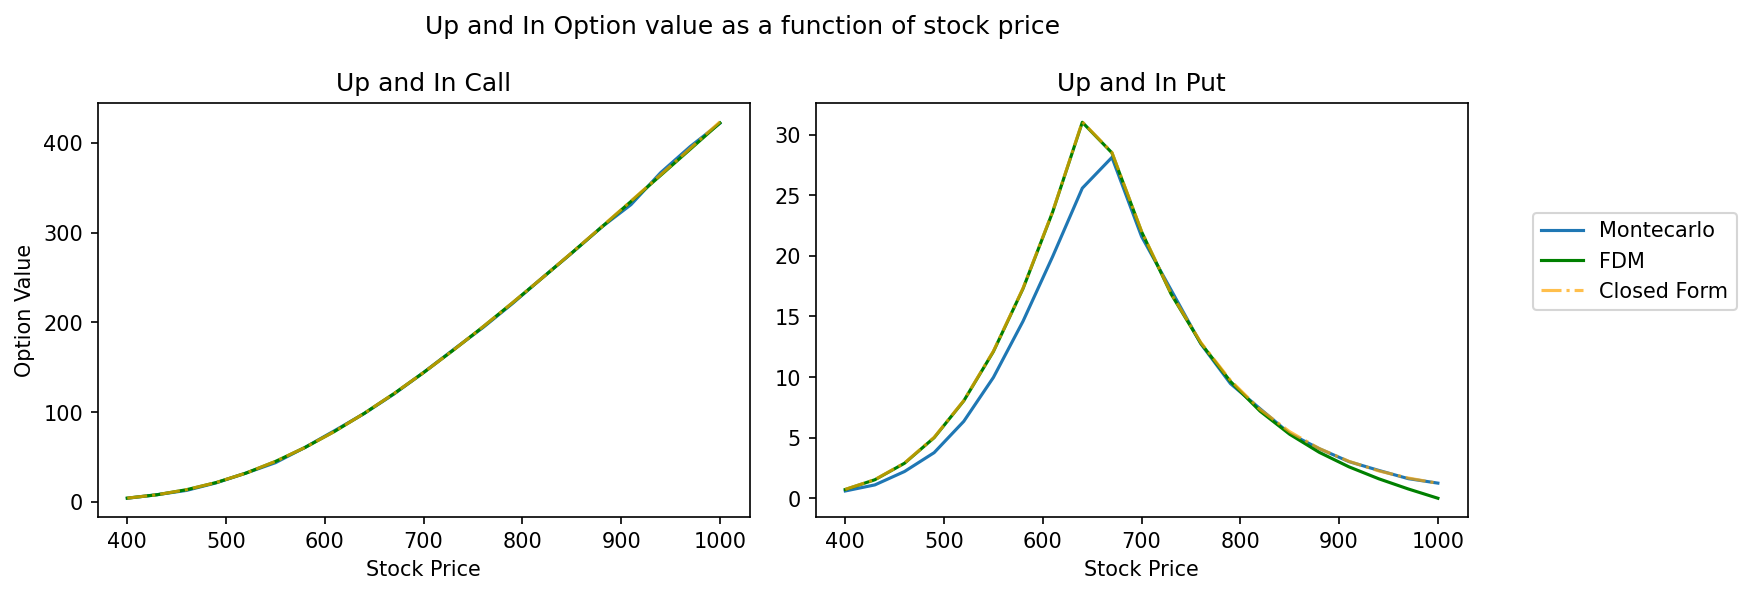

In [25]:
fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=150)

ax[0].plot(s2,call_MC,label='Montecarlo')
ax[0].plot(s2,call_FDM,label='FDM',color='green')
ax[0].plot(s2,call_CF,label='Closed Form',color='orange',alpha=0.7,ls='-.')
ax[0].set_xlabel('Stock Price')
ax[0].set_ylabel('Option Value')
ax[0].set_title('Up and In Call')

ax[1].plot(s2,put_MC,label='Montecarlo')
ax[1].plot(s2,put_FDM,label='FDM',color='green')
ax[1].plot(s2,put_CF,label='Closed Form',color='orange',alpha=0.7,ls='-.')
ax[1].set_xlabel('Stock Price')
ax[1].set_title('Up and In Put')

plt.suptitle("Up and In Option value as a function of stock price")
plt.tight_layout()
plt.legend(loc=(1.1,0.5))